### Programming Homework 1 - Learning Rate Analysis
#### LO, Li-yu 20997405 w/ lloac@connect.hkust.hk

In [8]:
#Don't change batch size
batch_size = 64

from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms

Download Binary Train/Test Data

In [9]:
# load train and test data
train_data = datasets.MNIST('./data/mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_data = datasets.MNIST('./data/mnist', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

# load only class 0 and 1
# and separate them into mini-batches, with batch size = 64
subset_indices_train = ((train_data.train_labels == 0) + (train_data.train_labels == 1)).nonzero().reshape(-1)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size, shuffle=False,sampler=SubsetRandomSampler(subset_indices_train))

subset_indices_test = ((test_data.test_labels == 0) + (test_data.test_labels == 1)).nonzero().reshape(-1)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=batch_size, shuffle=False,sampler=SubsetRandomSampler(subset_indices_test))

print(f"Train Data size: {len(subset_indices_train)}")
print(f"Test  Data size: {len(subset_indices_test)}")

print(f"Train no. of total batches: {len(train_loader)}")
print(f"Test  no. of total batches: {len(test_loader)}")


Train Data size: 12665
Test  Data size: 2115
Train no. of total batches: 198
Test  no. of total batches: 34


Hyperparameters Settings

In [46]:

optimize_option = "SGD"
# optimize_option = "SGD-M"
alpha_lr = 0.01
beta_momentum = 0.9
learning_rate_s = [0.2,0.1, 0.01, 0.001, 0.0001]

Test Model

In [47]:
# Test the Model
def test_model(W, accuracy_of_all):
    correct = 0.
    total = 0.
    for images, labels in test_loader:
        images_test = images.view(-1, 28*28)
        labels = 2*(labels.float()-0.5) # 64 X labels
        
        ## Put your prediction code here
        test_results = W(images_test).data.sign()
        
        correct += (test_results.view(-1).long() == labels).sum()
        total += images.shape[0]
    # print('Accuracy of the model on the test images: %f %%' % (100 * (correct.float() / total)))
    accuracy_of_all.append(100 * (correct.float() / total).item())

Train Model

In [48]:
import numpy as np

def train_model(learning_rate, loss_of_all_of_all_learning_rate):
    # Training the Model
    # Notice that newest Pytorch merge tensor and variable, so the additional Variable wrapping is no longer required.
    num_epochs = 20

    W = torch.nn.Linear(28*28,1, bias=True)

    loss_of_batch = 0
    loss_of_all = []
    accuracy_of_all = []

    alpha_lr=learning_rate
    
    if optimize_option == "SGD":
        optimizer = torch.optim.SGD(W.parameters(), lr=alpha_lr)
    else:
        optimizer = torch.optim.SGD(W.parameters(), lr=alpha_lr, momentum=beta_momentum)


    for epoch in range(num_epochs):
        loss_of_batch = 0
        
        for i, (images, labels) in enumerate(train_loader): # train_loader contains 198X of minibatches
                    
            images = images.view(-1, 28*28) # 64 X image (size=784) input
            #Convert labels from 0,1 to -1,1
            labels = 2*(labels.float()-0.5) # 64 X labels
            labels = labels.unsqueeze(1)
            
            # Forward
            W.zero_grad() # reset gradient for pytorch
            W_times_x = W(images)
            
            # loss
            loss = torch.log(1 + torch.exp(-labels * W_times_x)).mean()
            loss_of_batch += loss.item()
            
            # Backprop
            loss.backward()
        
            optimizer.step()

        # print(f"loss here: {loss_of_batch}")
        loss_of_all.append(loss_of_batch)
        
        test_model(W, accuracy_of_all)
        # print(accuracy_of_all)

    loss_of_all_of_all_learning_rate.append(loss_of_all)
    print(loss_of_all)


Train Model with different Step Size

In [49]:
loss_of_all_of_all_learning_rate = []

for what in learning_rate_s:
    train_model(what,loss_of_all_of_all_learning_rate)
    print(loss_of_all_of_all_learning_rate)


[2.154360134698436, 0.7149318276160557, 0.4960748706780578, 0.36971560062920616, 0.3327593082558451, 0.29060298894546577, 0.2779954130837723, 0.23249466283232323, 0.21072564890801004, 0.19579306024206744, 0.17440706379829862, 0.1556325598858166, 0.1538709537644536, 0.14126777971523552, 0.12972403368075902, 0.12398520232636656, 0.11850394966495514, 0.11064819515195268, 0.10484479548449599, 0.09772605530724832]
[[2.154360134698436, 0.7149318276160557, 0.4960748706780578, 0.36971560062920616, 0.3327593082558451, 0.29060298894546577, 0.2779954130837723, 0.23249466283232323, 0.21072564890801004, 0.19579306024206744, 0.17440706379829862, 0.1556325598858166, 0.1538709537644536, 0.14126777971523552, 0.12972403368075902, 0.12398520232636656, 0.11850394966495514, 0.11064819515195268, 0.10484479548449599, 0.09772605530724832]]
[2.206924100581091, 0.7916819353704341, 0.6270707311487058, 0.5393272855581017, 0.4784092414920451, 0.4164307785613346, 0.38462259045627434, 0.3416955132779549, 0.330569576

Plot Loss/Batch_no

In [50]:
loss_d_b_with_all_learning_rate = []

for what_lr in loss_of_all_of_all_learning_rate:
    loss_d_b = []
    for what in what_lr:
        loss_d_b.append(what/198)
    loss_d_b_with_all_learning_rate.append(loss_d_b)
        


Save Figure

20
5


/var/folders/40/w6l8c1fd18q5162bgks26d780000gn/T/ipykernel_86243/633792433.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bD" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x,what, '-bD',  c=col[i], mfc=col[i+5], mec='k')


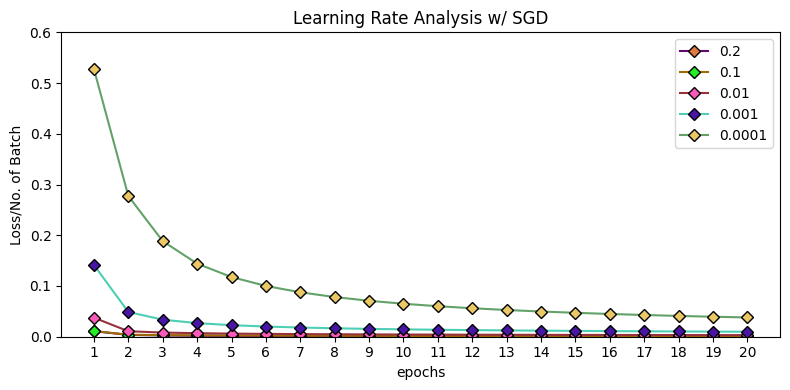

In [63]:
import matplotlib.pyplot as plt
filename = "LLR_" + optimize_option + "_step_size_analy.pdf"
plt.rcParams["figure.figsize"] = [8.0,4.0]
plt.rcParams["figure.autolayout"] = True

x = list(range(1,21))
print(len(x))
if optimize_option == "SGD":
    plt.title("Learning Rate Analysis w/ SGD")
else:
    plt.title("Learning Rate Analysis w/ SGD-M")

print(len(loss_d_b_with_all_learning_rate))

col = [(0.3763585924875623, 0.041870338113022654, 0.43216228306223137), (0.6239869210027108, 0.41721034785452926, 0.02715200051192157), (0.592970743182448, 0.19341667524297534, 0.22943916543632514), (0.29895701552933107, 0.8130881403472661, 0.7002013945197186), (0.38549663954284685, 0.6351669937775157, 0.41080906451168386), (0.8813838052014211, 0.4746038083961608, 0.25385863216196813), (0.1468528409953409, 0.9350666908815143, 0.14565948127409334), (0.9785484141240959, 0.3473094161953111, 0.7305549321473216), (0.27713428825838216, 0.08660136215547531, 0.6450874351739599), (0.9190679225609536, 0.7846493320356905, 0.4012906765274452)]

for i, what in enumerate(loss_d_b_with_all_learning_rate):
    plt.plot(x,what, '-bD',  c=col[i], mfc=col[i+5], mec='k')

plt.gca().legend(('0.2','0.1','0.01','0.001','0.0001'))
# 0.1, 0.01, 0.001, 0.0001
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("epochs", )
plt.ylabel("Loss/No. of Batch")
plt.ylim(0.0,0.6)
plt.savefig("./report/results/" + filename, format="pdf", bbox_inches="tight")
plt.show()


In [55]:
col = []
for i in range(10):
    col.append((np.random.random(), np.random.random(), np.random.random()))
    
print(col)

[(0.3763585924875623, 0.041870338113022654, 0.43216228306223137), (0.6239869210027108, 0.41721034785452926, 0.02715200051192157), (0.592970743182448, 0.19341667524297534, 0.22943916543632514), (0.29895701552933107, 0.8130881403472661, 0.7002013945197186), (0.38549663954284685, 0.6351669937775157, 0.41080906451168386), (0.8813838052014211, 0.4746038083961608, 0.25385863216196813), (0.1468528409953409, 0.9350666908815143, 0.14565948127409334), (0.9785484141240959, 0.3473094161953111, 0.7305549321473216), (0.27713428825838216, 0.08660136215547531, 0.6450874351739599), (0.9190679225609536, 0.7846493320356905, 0.4012906765274452)]
